#### Copyright 2018 Google LLC.

In [ ]:
#@title
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Clustering with Manual Similarity Measure

In this Colab, you will group chocolates in the
[Chocolate Bar Ratings](https://www.kaggle.com/rtatman/chocolate-bar-ratings)
dataset using the k-means clustering algorithm with a manual similarity measure. The dataset has ratings
of chocolate bars along with their cocoa percentage, bean type, bean origin,
maker name, and maker country. You will:

*   Load and clean the data.
*   Process the data.
*   Calculate similarity between pairs of chocolates.
*   Cluster the chocolates using k-means.
*   Check the clustering result using quality metrics.



# 1. Load and clean data

Run the following cell to load and clean the chocolate dataset. You do not need to
understand the code. The first few rows of the dataset are displayed. Inspect
the features and their values.

In [33]:
#@title Run cell to load and clean the dataset
%reset -f
import math

from matplotlib import pyplot as plt
import numpy as np
import numpy.linalg as nla
import pandas as pd
import seaborn as sns
import altair as alt
import re
import pdb  # for Python debugger
import sys
from os.path import join
import six

# Set the output display to have one digit for decimal places and limit it to
# printing 15 rows.
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

choc_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv", sep=",", encoding='latin-1')

# We can rename the columns.
choc_data.columns = ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']

# choc_data.dtypes

# Replace empty/null values with "Blend"
choc_data['bean_type'] = choc_data['bean_type'].fillna('Blend')

#@title Cast bean_type to string to remove leading 'u'
choc_data['bean_type'] = choc_data['bean_type'].astype(str)
choc_data['cocoa_percent'] = choc_data['cocoa_percent'].str.strip('%')
choc_data['cocoa_percent'] = pd.to_numeric(choc_data['cocoa_percent'])

#@title Correct spelling mistakes, and replace city with country name
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Amsterdam', 'Holland')\
.str.replace('U.K.', 'England')\
.str.replace('Niacragua', 'Nicaragua')\
.str.replace('Domincan Republic', 'Dominican Republic')

# Adding this so that Holland and Netherlands map to the same country.
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Holland', 'Netherlands')

def cleanup_spelling_abbrev(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        text = re.sub(i, j, text)
    return text

choc_data['specific_origin'] = choc_data['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

#@title Cast specific_origin to string
choc_data['specific_origin'] = choc_data['specific_origin'].astype(str)

#@title Replace null-valued fields with the same value as for specific_origin
choc_data['broad_origin'] = choc_data['broad_origin'].fillna(choc_data['specific_origin'])

#@title Clean up spelling mistakes and deal with abbreviations
choc_data['broad_origin'] = choc_data['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

# Change 'Trinitario, Criollo' to "Criollo, Trinitario"
# Check with choc_data['bean_type'].unique()
choc_data.loc[choc_data['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
# Confirm with choc_data[choc_data['bean_type'].isin(['Trinitario, Criollo'])]

# Fix chocolate maker names
choc_data.loc[choc_data['maker']=='Shattel','maker'] = 'Shattell'
choc_data['maker'] = choc_data['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

# Save the original column names
original_cols = choc_data.columns.values

choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


# 2. Preprocess Data

You will preprocess your data using the techniques described in
[Prepare Data](https://developers.google.com/machine-learning/clustering/prepare-data).

Let's start with the feature `review_date`. If you assume that chocolate making
did not change over the 10 years of data, then `review_date` has no correlation
with the chocolate itself. You can safely ignore the feature. However, as a good data scientist, you should be curious about your data. Let's
plot the distribution for `review date` using a function from the Seaborn data visualization library. It looks like no one ate chocolate in 2009 and 2013. However, the
overall chocolate eating trend is positive and very encouraging. This is a good
time to eat some chocolate yourself!

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


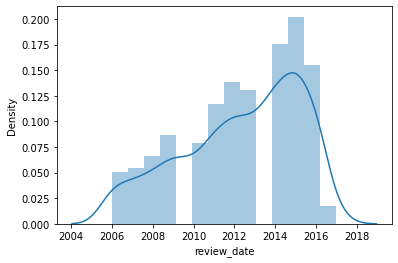

In [34]:
sns.distplot(choc_data['review_date'])

Plot the distribution for `rating`. Consider how you'd process this distribution. Then move ahead for the answer.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


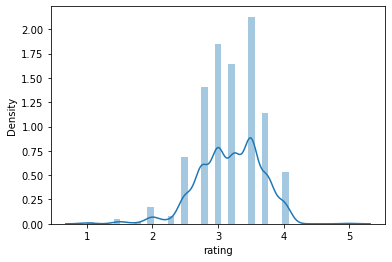

In [35]:
# check the distribution
sns.distplot(choc_data['rating'])

The distribution for `rating` is roughly a Gaussian distribution. How are Gaussian distributions processed? You know it. Normalize the data.

In [36]:
# its a Gaussian! So, use z-score to normalize the data
choc_data['rating_norm'] = (choc_data['rating'] - choc_data['rating'].mean()
                           ) / choc_data['rating'].std()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


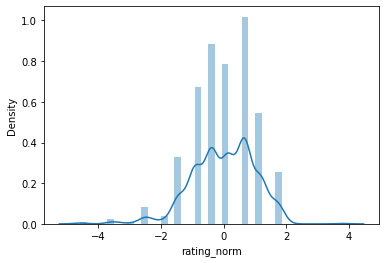

In [37]:
# check the distribution after normalization
sns.distplot(choc_data['rating_norm'])

Examine the distribution for `cocoa_percent` and consider how to process it. Then check below for the answer.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


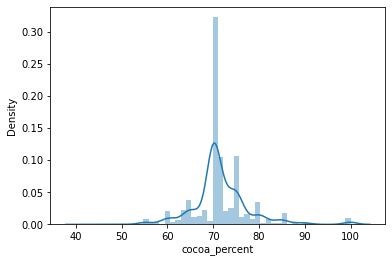

In [38]:
sns.distplot(choc_data['cocoa_percent'])

The distribution for `cocoa_percent` is close enough to a Gaussian distribution. Normalize the data.

In [39]:
choc_data['cocoa_percent_norm'] = (
    choc_data['cocoa_percent'] -
    choc_data['cocoa_percent'].mean()) / choc_data['cocoa_percent'].std()

Display the first few rows to check the normalization for `rating` and `cocoa_percent`.

In [40]:
choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm,cocoa_percent_norm
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome,1.18,-1.38
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,-0.91,-0.27
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,-0.39,-0.27
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,0.66,-0.27
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,0.66,-0.27


You have the cocoa beans' country of origin in `broad_origin` and the chocolates' country of manufacture in `maker_location`. However, to calculate similarity, you need the longitude and latitude
of the countries. Luckily, this geographic information is available in another table on
developers.google.com! The following code downloads the Dataset Publishing Language (DSPL)
Countries table and joins it with our chocolate reviews table, using the country
name as the key. Note that you are approximating countries by the latitude and longitude of their centers.

Display the first few rows to spot
check the processed data. Notice the newly created `maker_lat`, `maker_long`, `origin_lat`, and `origin_long` fields. Do the values in fields match your expectations? 

In [41]:
#@title Run code to add latitude and longitude data
# Load lat long data

countries_info = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/countries_lat_long.csv", sep=",", encoding='latin-1')

#Join the chocolate review and geographic information tables on maker country name
choc_data = pd.merge(
    choc_data, countries_info, left_on="maker_location", right_on="name")
choc_data.rename(
    columns={
        "longitude": "maker_long",
        "latitude": "maker_lat"
    }, inplace=True)
choc_data.drop(
    columns=["name", "country"], inplace=True)  # don't need this data

#Join the chocolate review and geographic information tables on origin country name
choc_data = pd.merge(
    choc_data, countries_info, left_on="broad_origin", right_on="name")
choc_data.rename(
    columns={
        "longitude": "origin_long",
        "latitude": "origin_lat"
    },
    inplace=True)
choc_data.drop(
    columns=["name", "country"], inplace=True)  # don't need this data

choc_data.head()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long
0,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo,-0.91,-0.27,46.23,2.21,8.62,0.82
1,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo,-0.39,-0.27,46.23,2.21,8.62,0.82
2,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo,0.66,-0.27,46.23,2.21,8.62,0.82
3,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru,0.66,-0.27,46.23,2.21,-9.19,-75.02
4,A. Morin,Pablino,1319,2014,70.00,France,4.00,Blend,Peru,1.70,-0.27,46.23,2.21,-9.19,-75.02


Check the distribution for the latitudes and longitudes and consider how to process the distributions. Then check below for the answer.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


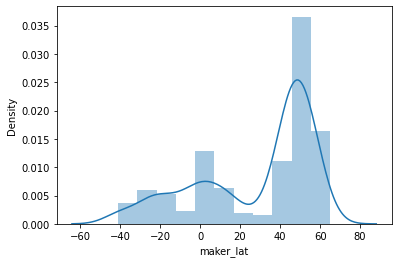

In [42]:
sns.distplot(choc_data['maker_lat'])

Since latitude and longitude don't follow a specific distribution, convert the
latitude and longitude information into quantiles. Display the last few rows to verify the quantile values.

In [43]:
numQuantiles = 20
colsQuantiles = ['maker_lat', 'maker_long', 'origin_lat', 'origin_long']

def createQuantiles(dfColumn, numQuantiles):
  return pd.qcut(dfColumn, numQuantiles, labels=False, duplicates='drop')


for string in colsQuantiles:
  choc_data[string] = createQuantiles(choc_data[string], numQuantiles)
  
choc_data.tail()

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long
782,Mesocacao,Honduras,1347,2014,70.00,Honduras,3.50,Blend,Honduras,0.66,-0.27,6,0,10,1
783,Malagos,"Davao,Mt Talamo foothills",1121,2013,65.00,Philippines,3.50,Trinitario,Philippines,0.66,-1.06,6,13,10,12
784,Mesocacao,El Salvador,1494,2015,80.00,Honduras,2.75,Blend,El Salvador,-0.91,1.31,6,0,10,0
785,Mesocacao,El Salvador,1494,2015,70.00,Honduras,3.00,Blend,El Salvador,-0.39,-0.27,6,0,10,0
786,Tan Ban Skrati,"Paramaribo,batch 20160043,01",1868,2016,70.00,Suriname,3.25,Trinitario,Suriname,0.13,-0.27,4,4,7,8


Quantile values range up to 20. Bring quantile values to the same scale as other feature data by scaling them to [0,1].

In [44]:
def minMaxScaler(numArr):
  minx = np.min(numArr)
  maxx = np.max(numArr)
  numArr = (numArr - minx) / (maxx - minx)
  return numArr


for string in colsQuantiles:
  choc_data[string] = minMaxScaler(choc_data[string])

The features `maker` and `bean_type` are categorical features. Convert
categorical features into one-hot encoding.

In [45]:
# duplicate the "maker" feature since it's removed by one-hot encoding function
choc_data['maker2'] = choc_data['maker']
choc_data = pd.get_dummies(choc_data, columns=['maker2'], prefix=['maker'])
# similarly, duplicate the "bean_type" feature
choc_data['bean_type2'] = choc_data['bean_type']
choc_data = pd.get_dummies(choc_data, columns=['bean_type2'], prefix=['bean'])

After clustering, when you interpret the results, the processed feature data is
hard to read. Save the original feature data in a new dataframe so you can
reference it later. Keep only the processed data in `choc_data`.

In [46]:
# Split dataframe into two frames: Original data and data for clustering
choc_data_backup = choc_data.loc[:, original_cols].copy(deep=True)
choc_data.drop(columns=original_cols, inplace=True)

# get_dummies returned ints for one-hot encoding but we want floats so divide by
# 1.0
# Note: In the latest version of "get_dummies", you can set "dtype" to float
choc_data = choc_data / 1.0

Inspect the last few records to ensure your precious chocolate data is looking
good! Remember that `choc_data` only shows columns with processed data because the columns holding the original data were moved to `choc_data_backup`.

In [47]:
choc_data.tail()

,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long,maker_A. Morin,maker_AMMA,maker_Adi,maker_Aequare (Gianduja),maker_Ah Cacao,maker_Akesson's (Pralus),maker_Alain Ducasse,maker_Alexandre,maker_Amatller (Simon Coll),maker_Amazona,maker_Ambrosia,maker_Amedei,maker_Ara,maker_Bahen & Co.,maker_Bakau,maker_Belcolade,maker_Belyzium,maker_Benoit Nihant,maker_Beschle (Felchlin),maker_Bonnat,maker_Bouga Cacao (Tulicorp),maker_Bright,maker_Britarev,maker_C-Amaro,maker_Cacao Arabuco,maker_Cacao Barry,maker_Cacao Hunters,maker_Cacao Sampaka,maker_Cacao Store,maker_Cacao de Origen,maker_Cacao de Origin,maker_Cacaosuyo (Theobroma Inversiones),maker_Cacaoyere (Ecuatoriana),maker_Callebaut,...,maker_Tsara (Cinagra),maker_Un Dimanche A Paris,maker_Urzi,maker_Valrhona,maker_Vao Vao (Chocolaterie Robert),maker_Vietcacao (A. Morin),maker_Wellington Chocolate Factory,maker_Whittakers,maker_Wilkie's Organic,maker_Xocolat,maker_Zart Pralinen,maker_Zokoko,maker_Zotter,maker_organicfair,bean_Blend,"bean_Blend-Forastero,Criollo",bean_CCN51,bean_Criollo,bean_Criollo (Amarru),bean_Criollo (Ocumare 61),bean_Criollo (Ocumare 67),bean_Criollo (Ocumare 77),bean_Criollo (Porcelana),bean_Criollo (Wild),"bean_Criollo, Forastero","bean_Criollo, Trinitario",bean_Forastero,bean_Forastero (Amelonado),bean_Forastero (Arriba),bean_Forastero (Arriba) ASS,bean_Forastero (Arriba) ASSS,bean_Forastero (Catongo),bean_Forastero (Nacional),bean_Forastero (Parazinho),bean_Nacional,bean_Nacional (Arriba),bean_Trinitario,bean_Trinitario (85% Criollo),bean_Trinitario (Scavina),"bean_Trinitario, TCGA"
782,0.66,-0.27,0.40,0.00,0.77,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
783,0.66,-1.06,0.40,0.87,0.77,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
784,-0.91,1.31,0.40,0.00,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
785,-0.39,-0.27,0.40,0.00,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
786,0.13,-0.27,0.27,0.27,0.54,0.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


# 3. Calculate Manual Similarity

You've worked hard to process the data! Now calculating similarity between a
pair of chocolates is simple because all the features are numeric and in the
same range. For any two chocolates, simply find the root mean square error
(RMSE) of all features.

First run this code to define the similarity function.

In [48]:
def getSimilarity(obj1, obj2):
  len1 = len(obj1.index)
  len2 = len(obj2.index)
  if not (len1 == len2):
    print("Error: Compared objects must have same number of features.")
    sys.exit()
    return 0
  else:
    similarity = obj1 - obj2
    similarity = np.sum((similarity**2.0) / 10.0)
    similarity = 1 - math.sqrt(similarity)
    return similarity

Now calculate the similarity between the first chocolate and the next 4
chocolates. Verify the calculated similarity against your intuitive expectations
by comparing the calculated similarity to the actual feature data shown in the
next cell.

If you're curious about similarities between other chocolates, do modify the
code below and take a look!

In [49]:
choc1 = 0  #@param
chocsToCompare = [1, 4]  #@param

print("Similarity between chocolates " + str(choc1) + " and ...")

for ii in range(chocsToCompare[0], chocsToCompare[1] + 1):
  print(str(ii) + ": " + str(
      getSimilarity(choc_data.loc[choc1], choc_data.loc[ii])))

print("\n\nFeature data for chocolate " + str(choc1))
print(choc_data_backup.loc[choc1:choc1, :])
print("\n\nFeature data for compared chocolates " + str(chocsToCompare))
print(choc_data_backup.loc[chocsToCompare[0]:chocsToCompare[1], :])

Similarity between chocolates 0 and ...
1: 0.8346304947537486
2: 0.5038914842612459
3: 0.4555557720237311
4: 0.14327793910573605


Feature data for chocolate 0
      maker specific_origin  reference_number  ...  rating  bean_type broad_origin
0  A. Morin           Kpime              1676  ...    2.75      Blend         Togo

[1 rows x 9 columns]


Feature data for compared chocolates [1, 4]
      maker specific_origin  reference_number  ...  rating  bean_type broad_origin
1  A. Morin          Atsane              1676  ...    3.00      Blend         Togo
2  A. Morin           Akata              1680  ...    3.50      Blend         Togo
3  A. Morin          Quilla              1704  ...    3.50      Blend         Peru
4  A. Morin         Pablino              1319  ...    4.00      Blend         Peru

[4 rows x 9 columns]


# 4. Cluster Chocolate Dataset

We're ready to cluster the chocolates! Run the code to setup the k-means
clustering functions. You do not need to understand the code.

**Note**: If you're following the self study, then before running the rest of
this Colab, read the sections on
[k-means](https://developers.google.com/machine-learning/clustering/algorithm/run-algorithm)
and
[quality metrics](https://developers.google.com/machine-learning/clustering/interpret).

In [50]:
#@title Run cell to setup functions
def dfSimilarity(df, centroids):
  ### dfSimilarity = Calculate similarities for dataframe input
  ### We need to calculate ||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|
  ### Implement this with matrix operations
  ### See the Appendix for further explanation
  numPoints = len(df.index)
  numCentroids = len(centroids.index)
  ## Strictly speaking, we don't need to calculate the norm of points
  # because it adds a constant bias to distances
  # But calculating it so that the similarity doesn't go negative
  # And that we expect similarities in [0,1] which aids debugging
  pointNorms = np.square(nla.norm(df, axis=1))
  pointNorms = np.reshape(pointNorms, [numPoints, 1])
  ## Calculate the norm of centroids
  centroidNorms = np.square(nla.norm(centroids, axis=1))
  centroidNorms = np.reshape(centroidNorms, (1, numCentroids))
  ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
  similarities = pointNorms + centroidNorms - 2.0 * np.dot(
      df, np.transpose(centroids))
  # Divide by the number of features
  # Which is 10 because the one-hot encoding means the "Maker" and "Bean" are
  # weighted twice
  similarities = similarities / 10.0
  # numerical artifacts lead to negligible but negative values that go to NaN on the root
  similarities = similarities.clip(min=0.0)
  # Square root since it's ||a-b||^2
  similarities = np.sqrt(similarities)
  return similarities


def initCentroids(df, k, feature_cols):
  # Pick 'k' examples are random to serve as initial centroids
  limit = len(df.index)
  centroids_key = np.random.randint(0, limit - 1, k)
  centroids = df.loc[centroids_key, feature_cols].copy(deep=True)
  # the indexes get copied over so reset them
  centroids.reset_index(drop=True, inplace=True)
  return centroids


def pt2centroid(df, centroids, feature_cols):
  ### Calculate similarities between all points and centroids
  ### And assign points to the closest centroid + save that distance
  numCentroids = len(centroids.index)
  numExamples = len(df.index)
  # dfSimilarity = Calculate similarities for dataframe input
  dist = dfSimilarity(df.loc[:, feature_cols], centroids.loc[:, feature_cols])
  df.loc[:, 'centroid'] = np.argmin(dist, axis=1)  # closest centroid
  df.loc[:, 'pt2centroid'] = np.min(dist, axis=1)  # minimum distance
  return df


def recomputeCentroids(df, centroids, feature_cols):
  ### For every centroid, recompute it as an average of the points
  ### assigned to it
  numCentroids = len(centroids.index)
  for cen in range(numCentroids):
    dfSubset = df.loc[df['centroid'] == cen,
                      feature_cols]  # all points for centroid
    if not (dfSubset.empty):  # if there are points assigned to the centroid
      clusterAvg = np.sum(dfSubset) / len(dfSubset.index)
      centroids.loc[cen] = clusterAvg
  return centroids


def kmeans(df, k, feature_cols, verbose):
  flagConvergence = False
  maxIter = 100
  iter = 0  # ensure kmeans doesn't run for ever
  centroids = initCentroids(df, k, feature_cols)
  while not (flagConvergence):
    iter += 1
    #Save old mapping of points to centroids
    oldMapping = df['centroid'].copy(deep=True)
    # Perform k-means
    df = pt2centroid(df, centroids, feature_cols)
    centroids = recomputeCentroids(df, centroids, feature_cols)
    # Check convergence by comparing [oldMapping, newMapping]
    newMapping = df['centroid']
    flagConvergence = all(oldMapping == newMapping)
    if verbose == 1:
      print('Total distance:', str(np.sum(df['pt2centroid'])))
    if (iter > maxIter):
      print('k-means did not converge! Reached maximum iteration limit of ' \
            , str(maxIter), '.')
      sys.exit()
      return
  print('k-means converged for ', str(k), ' clusters', \
        ' after ', str(iter), ' iterations!')
  return [df, centroids]

Run the cell to cluster the chocolate dataset, where `k` is the number of
clusters.

On every iteration of k-means, the output shows how the sum of distances from all examples to their centroids reduces, such that k-means always converges. The following table shows the data for the first few chocolates. On the extreme right of the table, check the assigned centroid for each example in the `centroid` column and the distance from the example to its centroid in the `pt2centroid` column.

In [51]:
k = 30  #@param

feature_cols = choc_data.columns.values  # save original columns
# initialize every point to an impossible value, the k+1 cluster
choc_data['centroid'] = k
# init the point to centroid distance to an impossible value "2" (>1)
choc_data['pt2centroid'] = 2
[choc_data, centroids] = kmeans(choc_data, k, feature_cols, 1)
print("Data for the first few chocolates, with 'centroid' and 'pt2centroid' on"
      ' the extreme right:')
choc_data.head()

Total distance: 417.9299052127359
Total distance: 332.0544645281881
Total distance: 327.4364054625245
Total distance: 326.25887882055326
Total distance: 325.7614275349581
Total distance: 325.01770140766814
Total distance: 324.6286335513447
Total distance: 324.28344372758625
Total distance: 323.57017598759
Total distance: 322.97967329833494
Total distance: 322.723845089837
Total distance: 322.55781263359415
Total distance: 322.5057519737122
Total distance: 322.38744032194734
Total distance: 322.2681786291949
k-means converged for  30  clusters  after  15  iterations!
Data for the first few chocolates, with 'centroid' and 'pt2centroid' on the extreme right:


,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long,maker_A. Morin,maker_AMMA,maker_Adi,maker_Aequare (Gianduja),maker_Ah Cacao,maker_Akesson's (Pralus),maker_Alain Ducasse,maker_Alexandre,maker_Amatller (Simon Coll),maker_Amazona,maker_Ambrosia,maker_Amedei,maker_Ara,maker_Bahen & Co.,maker_Bakau,maker_Belcolade,maker_Belyzium,maker_Benoit Nihant,maker_Beschle (Felchlin),maker_Bonnat,maker_Bouga Cacao (Tulicorp),maker_Bright,maker_Britarev,maker_C-Amaro,maker_Cacao Arabuco,maker_Cacao Barry,maker_Cacao Hunters,maker_Cacao Sampaka,maker_Cacao Store,maker_Cacao de Origen,maker_Cacao de Origin,maker_Cacaosuyo (Theobroma Inversiones),maker_Cacaoyere (Ecuatoriana),maker_Callebaut,...,maker_Urzi,maker_Valrhona,maker_Vao Vao (Chocolaterie Robert),maker_Vietcacao (A. Morin),maker_Wellington Chocolate Factory,maker_Whittakers,maker_Wilkie's Organic,maker_Xocolat,maker_Zart Pralinen,maker_Zokoko,maker_Zotter,maker_organicfair,bean_Blend,"bean_Blend-Forastero,Criollo",bean_CCN51,bean_Criollo,bean_Criollo (Amarru),bean_Criollo (Ocumare 61),bean_Criollo (Ocumare 67),bean_Criollo (Ocumare 77),bean_Criollo (Porcelana),bean_Criollo (Wild),"bean_Criollo, Forastero","bean_Criollo, Trinitario",bean_Forastero,bean_Forastero (Amelonado),bean_Forastero (Arriba),bean_Forastero (Arriba) ASS,bean_Forastero (Arriba) ASSS,bean_Forastero (Catongo),bean_Forastero (Nacional),bean_Forastero (Parazinho),bean_Nacional,bean_Nacional (Arriba),bean_Trinitario,bean_Trinitario (85% Criollo),bean_Trinitario (Scavina),"bean_Trinitario, TCGA",centroid,pt2centroid
0,-0.91,-0.27,0.60,0.40,0.62,0.77,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18,0.34
1,-0.39,-0.27,0.60,0.40,0.62,0.77,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18,0.37
2,0.66,-0.27,0.60,0.40,0.62,0.77,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16,0.28
3,0.66,-0.27,0.60,0.40,0.15,0.23,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16,0.27
4,1.70,-0.27,0.60,0.40,0.15,0.23,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9,0.37


## Inspect Clustering Result

Inspect the chocolates in different clusters by changing the parameter `clusterNumber`
in the next cell and running the cell. Consider these questions as you inspect the clusters:

*   Are the clusters meaningful?
*   Do the clusters weight certain features more than others? Why?
*   Does changing the number of clusters make the clusters more or less
    meaningful?

After considering these questions, expand the next section for a discussion of clustering results.

In [52]:
clusterNumber = 7  #@param
choc_data_backup.loc[choc_data['centroid'] == clusterNumber, :]

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
93,Pralus,Chuao,486,2010,75.00,France,3.50,Trinitario,Venezuela
95,Pralus,"Barlovento,Venezuela",32,2006,75.00,France,3.50,Trinitario,Venezuela
166,Cacao de Origen,Chuao,1688,2015,77.00,Venezuela,3.50,Trinitario,Venezuela
167,Cacao de Origen,Rio Caribe,1692,2015,75.00,Venezuela,3.25,Trinitario,Venezuela
170,Cacao de Origen,"Chuao,Aragua region",1391,2014,75.00,Venezuela,3.50,Trinitario,Venezuela
...,...,...,...,...,...,...,...,...,...
656,Grenada Chocolate Co.,Grenada,494,2010,82.00,Grenada,3.25,Trinitario,Grenada
688,Adi,"Vanua Levu,Toto,A",705,2011,80.00,Fiji,3.25,Trinitario,Fiji
731,Belyzium,Belize south,1768,2016,78.00,Germany,3.00,Trinitario,Belize
732,Belyzium,Belize south,1768,2016,83.00,Germany,3.50,Trinitario,Belize


### Solution: Discussion of Clustering Results

Click below for the answer.

**Discussion**: The clustering result does unintentionally weight certain
features more than others.

That's because a given chocolate maker will have the same country of
manufacture, which leads to mutual information between the features `maker`,
`maker_lat`, and `maker_long`. Similarly, suppose each country tends to grow a
particular type of bean, then there is mutual information between `origin_lat`,
`origin_long`, and `bean_type`.

As a result, features that share mutual information are effectively weighted
more strongly than uncorrelated features. The solution is to use a supervised
similarity measure because the DNN eliminates correlated information. See
[k-means advantages and disadvantages](https://developers.google.com/machine-learning/clustering/algorithm/advantages-disadvantages).

Now consider the one-hot encoding. Chocolates that have different makers will
differ by 1 in two columns. Similarly, chocolates that are made of different
bean types will differ by 1 in two features. Therefore, differences in makers
and bean types will be weighted twice as much as other features. This uneven
weighting skews the clustering result.

# 5. Quality Metrics for Clusters

For the clusters, let's calculate the metrics discussed in
[Interpret Results](https://developers.google.com/machine-learning/clustering/interpret).
Read that course content before starting this code section.

Run the next cell to set up functions.

In [53]:
#@title Run cell to set up functions { display-mode: "form" }
def clusterCardinality(df):
  k = np.max(df['centroid']) + 1
  if six.PY2:
    k = k.astype(int)
  print('Number of clusters:', str(k))
  clCard = np.zeros(k)
  for kk in range(k):
    clCard[kk] = np.sum(df['centroid'] == kk)
  if six.PY2:
    clCard = clCard.astype(int)
  # print "Cluster Cardinality:"+str(clCard)
  plt.figure()
  plt.bar(range(k), clCard)
  plt.title('Cluster Cardinality')
  plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
  plt.ylabel('Points in Cluster')
  return clCard


def clusterMagnitude(df):
  k = np.max(df['centroid']) + 1
  if six.PY2:
    k = k.astype(int)
  cl = np.zeros(k)
  clMag = np.zeros(k)
  for kk in range(k):
    idx = np.where(df['centroid'] == kk)
    idx = idx[0]
    clMag[kk] = np.sum(df.loc[idx, 'pt2centroid'])
  # print "Cluster Magnitude:",clMag #precision set using np pref
  plt.figure()
  plt.bar(range(k), clMag)
  plt.title('Cluster Magnitude')
  plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
  plt.ylabel('Total Point-to-Centroid Distance')
  return clMag


def plotCardVsMag(clCard, clMag):
  plt.figure()
  plt.scatter(clCard, clMag)
  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.title('Magnitude vs Cardinality')
  plt.ylabel('Magnitude')
  plt.xlabel('Cardinality')


def clusterQualityMetrics(df):
  clCard = clusterCardinality(df)
  clMag = clusterMagnitude(df)
  plotCardVsMag(clCard, clMag)

Calculate the following metrics by running the next cell:

*   cardinality of your clusters
*   magnitude of your clusters
*   cardinality vs Magnitude

From the plots, find clusters that are outliers and clusters that are average.
Compare the examples in outlier clusters versus those in average clusters by
changing `clusterNumber` in the previous section.

Number of clusters: 30


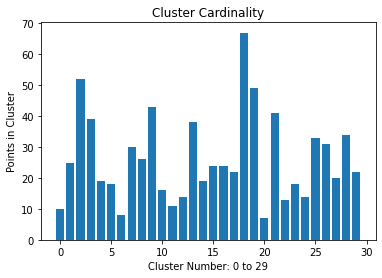

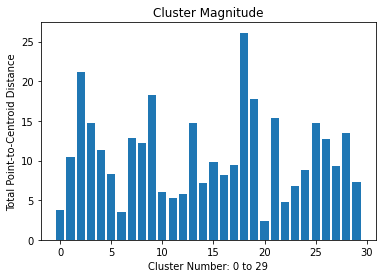

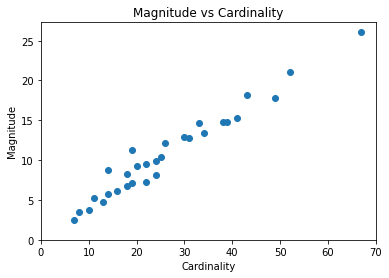

In [54]:
clusterQualityMetrics(choc_data)

## Find Optimum Number of Clusters

You want to find the right number of clusters as you did in the previous
programming exercise. For details, read "*Step Three: Optimum Number of
Clusters*" on the page
[Interpret Results](https://developers.google.com/machine-learning/clustering/interpret).

Run the code below. Does the plot follow the form shown on "*Interpret Results*"? What's the
optimum number of clusters? Experiment with the parameters below if necessary. After considering the questions, expand the next section for a discussion.

### Solution: Discussion on optimum number of clusters

Click below for the solution.

k-means converged for  5  clusters  after  15  iterations!
k-means converged for  7  clusters  after  11  iterations!
k-means converged for  9  clusters  after  19  iterations!
k-means converged for  11  clusters  after  17  iterations!
k-means converged for  13  clusters  after  27  iterations!
k-means converged for  15  clusters  after  16  iterations!
k-means converged for  17  clusters  after  15  iterations!
k-means converged for  19  clusters  after  11  iterations!
k-means converged for  21  clusters  after  23  iterations!
k-means converged for  23  clusters  after  16  iterations!
k-means converged for  25  clusters  after  21  iterations!
k-means converged for  27  clusters  after  22  iterations!
k-means converged for  29  clusters  after  14  iterations!
k-means converged for  31  clusters  after  14  iterations!
k-means converged for  33  clusters  after  10  iterations!
k-means converged for  35  clusters  after  11  iterations!
k-means converged for  37  clusters  after 

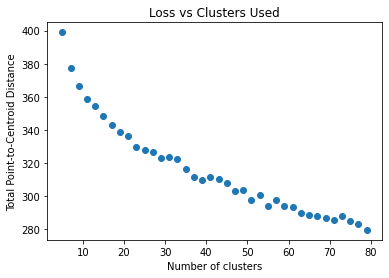

In [55]:
# Plot loss vs number of clusters
def lossVsClusters(kmin, kmax, kstep, choc_data):
  kmax += 1  # include kmax-th cluster in range
  kRange = range(kmin, kmax, kstep)
  loss = np.zeros(len(kRange))
  lossCtr = 0
  for kk in kRange:
    [choc_data, centroids] = kmeans(choc_data, kk, feature_cols, 0)
    loss[lossCtr] = np.sum(choc_data['pt2centroid'])
    lossCtr += 1
  plt.scatter(kRange, loss)
  plt.title('Loss vs Clusters Used')
  plt.xlabel('Number of clusters')
  plt.ylabel('Total Point-to-Centroid Distance')


kmin = 5  # @param
kmax = 80  # @param
kstep = 2  # @param
lossVsClusters(kmin, kmax, kstep, choc_data)

**Discussion**: The ideal plot of loss vs clusters has a clear inflection point beyond which the decrease in loss flattens out. Here, the plot lacks an obvious inflection point. However, the decrease in loss evens out twice, at approximately `k = 15`
and `k = 35`, suggesting that `k` has optimum values close to 15 and 35. Note that your plot can differ due to the inherent randomness in the k-means algorithm.

You
typically see a plot with a clear inflection point plot when the data has naturally clumped
examples. When data doesn't have natural clumps, this plot only hints
as to the optimum value for `k`.

## Discussion

On the page
[Supervised Similarity Measure](https://developers.google.com/machine-learning/clustering/similarity/supervised-similarity),
read the "*Comparison of Manual and Supervised Measures*". Try to connect the description of a manual similarity measure to what your learned from this codelab. Then click below to view the discussion. Lastly, **keep this Colab open** to compare the results with the next Colab that uses a supervised similarity measure.

The Colab demonstrates the following characteristics of a manual similarity metric:

*   **Does not eliminate redundant information in correlated features**. As
    discussed in this [section](#scrollTo=MJtuP9w5jJHq), our manual similarity
    measure did not eliminate redundant information between features.
*   **Provides insight into calculated similarities**. Looking at the clustering
    results, you could see how the maker location and bean origin had a greater
    influence on the clustering result. You saw how the one-hot encoding
    resulted in weighting maker and bean type twice as much as other features.
*   **Suitable for small datasets with few features**. Yes, you could easily
    construct a manual similarity measure for the chocolate dataset since it has
    less than two thousand examples and only nine features.
*   **Not suitable for large datasets with many features**. If the chocolate dataset
    had dozens of features and many thousands of examples, it would be difficult
    to construct a correct similarity measure and then verify the similarity
    measure across the dataset.

# Appendix: Calculating Point to Centroid Distance for Large Datasets

On every iteration of k-means, your code calculates the distance between every
point and every centroid. When you cluster large numbers of points using many centroids, you must implement
this operation efficiently. Let's see how.

Assume you have a vector "P" for a point, and another vector "C" for a centroid.
You need to calculate $||P-C||^2$. Mathematically:

$$||P-C||^2 = |P|^2 + |C|^2 - 2 \cdot P \cdot C$$

The code below generalizes this operation to matrices that represent arbitrary
numbers of points and centroids. Using the code, you can calculate the
point-centroid distances for all combinations of your points and centroids.

In [57]:
#@title
# Calculate distances between "A" point and "B" centroids to return
# axb array where a_i,b_j distance is at (i,j) position
A = np.array([[1, 2, 3],\
              [3, 1, 2],\
              [0, 0, 0]])
A = A / np.max(A)
B = np.array([[4, 5, 6],\
              [6, 6, 6]])
B = B / np.max(B)
numPoints = A.shape[0]
numCentroids = B.shape[0]
pointNorms = np.reshape(nla.norm(A, axis=1)**2.0, [numPoints, 1])
centroidNorms = np.reshape(nla.norm(B, axis=1)**2.0, (1, numCentroids))
print("""Distance matrix of size 'p' by 'c' where Distance between 
point 'p' and centroid 'c' is at (p,c).""")
print(pointNorms, centroidNorms - 2.0 * np.dot(A, np.transpose(B)))

Distance matrix of size 'p' by 'c' where Distance between 
point 'p' and centroid 'c' is at (p,c).
[[1.56]
 [1.56]
 [0.  ]] [[-1.42 -1.  ]
 [-1.08 -1.  ]
 [ 2.14  3.  ]]
